# Neural Network for Sentiment Analysis

## Experimenting with bi-grams BoW

In [1]:
import numpy as np 
import pandas as pd
from bs4 import BeautifulSoup
import string
import re
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import time
import datetime
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# scipy.special for the sigmoid function expit()
import scipy.special
# library for plotting arrays
import matplotlib.pyplot
# ensure the plots are inside this notebook, not an external window
%matplotlib inline

## Extracting Data as BoW, bigrams

In [2]:
def get_wordnet_pos(tag):
    """Take a POS tag and return the corresponding WordNet POS tag.

    Parameter:
    -tag: a POS tag.
    """
    
    if tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('R'):
        return wordnet.ADV
    elif tag.startswith('J'):
        return wordnet.ADJ
    else:
        return wordnet.NOUN  # Default to noun if the POS is not recognized

In [3]:
def preprocess_text(text,remove_digits=True):
    """Read a csv file and clean the text by removing html string using the BeautifulSoup library.
    Apply tokenization and lemmatization.
    Return the df with the preprocessed text in the respective column.
    
    Parameters:
    -reviews_file: path to a csv file containing the final reviews, provided as a Python string.
    -text_column: name of the column in the csv file where the reviews are stored, provided as a Python string.
    """
    
    #removing HTML tags using BeautifulSoup
    soup = BeautifulSoup(text, 'html.parser')
    text = soup.get_text()

    #removing square brackets
    text = re.sub('\[[^]]*\]', '', text)
    
    #removing special characters
    if remove_digits:
        text = re.sub('[^a-zA-Z\s]', '', text)
    else:
        text = re.sub('[^a-zA-Z0-9\s]', '', text)
    
    #lowercasing the text
    text = text.lower()

    #tokenization with NLTK
    tokens = nltk.word_tokenize(text)

    #removing stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    #lemmatization with POS tagging
    lemmatizer = WordNetLemmatizer()
    pos_tags = nltk.pos_tag(tokens) #applying the NLTK POS tags to tokens
    lemmatized_tokens = [lemmatizer.lemmatize(token, pos=get_wordnet_pos(pos_tag)) for token, pos_tag in pos_tags] #lemmatizing each token based on its POS
    lemmatized_text = ' '.join(lemmatized_tokens)  #joining lemmatized tokens back into a single string

    return lemmatized_text

###part of the code as seen on https://www.kaggle.com/code/aashidutt3/sentiment-analysis-sephora-reviews/notebook on Jan 23rd

In [4]:
def create_count_vectorizer(reviews_file, text_column,min_df=300):
    """Read a csv file and clean the text by removing html string.
    Preprocess the text, applies CountVectorizer with words occuring at least the amount of times specified.
    Return the transformed matrix and the fitted CountVectorizer object.
    
    Parameters:
    -reviews_file: path to a csv file containing the final reviews, provided as a Python string.
    -text_column: name of the column in the csv file where the reviews are stored, provided as a Python string.
    - min_df: minimum frequency of words accross documents for CountVectorizer, default is 300.
    """

    #reading the csv file into a DataFrame with pandas
    df = pd.read_csv(reviews_file)
    
    # applying the preprocessing function to the text column
    df[text_column] = df[text_column].apply(preprocess_text)

    vectorizer = CountVectorizer(min_df=min_df, #if a token appears fewer times than this, across all documents, it will be ignored
                                tokenizer=nltk.word_tokenize, # using the nltk tokenizer
                                ngram_range=(2,2))
                                
    
    # Fit and transform the cleaned text data
    bow_matrix = vectorizer.fit_transform(df[text_column])

    return bow_matrix, vectorizer

In [5]:
output_file_path = './sephora-data/sa-reviews_smaller.csv'
text_column = 'text'
review_counts, review_vec = create_count_vectorizer(output_file_path, text_column)

C:\Users\User\AppData\Local\Temp\ipykernel_9948\1671045480.py:12: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')
C:\Users\User\AppData\Local\Temp\ipykernel_9948\1671045480.py:12: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')
C:\Users\User\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [6]:
#Total number of word features or the length of the total vector
print('Total number of words in the vector representing dimensions in the model:', len(review_vec.vocabulary_))

Total number of words in the vector representing dimensions in the model: 277


In [7]:
# First 50 feature names
print(list(review_vec.get_feature_names_out())[:50])

['absolutely love', 'absorb skin', 'acne prone', 'acne scar', 'around eye', 'buy full', 'care routine', 'change skin', 'cleanse balm', 'clear skin', 'clog pore', 'combination skin', 'combo skin', 'complimentary influenster', 'continue use', 'dark circle', 'dark spot', 'day use', 'dead skin', 'definitely recommend', 'didnt anything', 'didnt feel', 'didnt like', 'didnt notice', 'didnt really', 'didnt see', 'didnt work', 'difference skin', 'doesnt feel', 'doesnt leave', 'doesnt make', 'doesnt work', 'dont feel', 'dont get', 'dont know', 'dont like', 'dont see', 'dont think', 'double cleanse', 'drunk elephant', 'dry lip', 'dry patch', 'dry sensitive', 'dry skin', 'easy use', 'even though', 'ever use', 'every day', 'every night', 'every time']


In [8]:
#review_counts represents the data according to the model of review_vec
#inspecting the dimensions as a feature array by getting the shape: the rows (reviews) and columns (the word vector length).
review_counts.shape

(49905, 277)

In [9]:
#converting the matrix to an array and getting the 500th element to look at the vector values for slots [:100] out of the total dimensions:
datarow = 500
print(review_counts.toarray()[datarow][:100])

[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [10]:
# Find the maximum count in the entire matrix
max_count = review_counts.max()

print("Maximum count:", max_count)

Maximum count: 13


## Splitting Data into Train and Test

In [11]:
def split_data(data, labels, test_size=0.15, dev_size=0.15, random_state=None):
    """
    Split data into training, development, and test sets.

    Parameters:
    - data: features, e.g., count vectorizer model derived from all the data.
    - labels: the labels for all the data
    - test_size: size of the test set for the first split, resulting in the test set. Default is set to 0.15.
    - dev_size: size of the test set for the second split, resulting in the development set. Default is set to 0.15.
    - random_state: seed for reproducibility. Default is None.

    Returns:
    - tuple of (data_train, data_dev, data_test, labels_train, labels_dev, labels_test)
    """
    # first split: data into training and test sets
    data_tr, data_test, labels_tr, labels_test = train_test_split(data, labels, test_size=test_size, random_state=random_state)

    # second split: training data into training and dev sets
    data_train, data_dev, labels_train, labels_dev = train_test_split(data_tr, labels_tr, test_size=dev_size, random_state=random_state)

    return data_train, data_dev, data_test, labels_train, labels_dev, labels_test

In [12]:
df = pd.read_csv(output_file_path)

reviews_train, reviews_dev, reviews_test, gold_labels_train, gold_labels_dev, gold_labels_test = split_data(review_counts,
                                                                                                            df['label'],
                                                                                                            random_state=42)


In [13]:
print("Training texts:", len(reviews_train.toarray()))
print("Training labels:", len(gold_labels_train))
print("Test texts:", len(reviews_test.toarray()))
print("Test labels:", len(gold_labels_test))
print("Development texts:", len(reviews_dev.toarray()))
print("Development labels:", len(gold_labels_dev))

Training texts: 36056
Training labels: 36056
Test texts: 7486
Test labels: 7486
Development texts: 6363
Development labels: 6363


In [14]:
#one training instance looks like this:
reviews_train[100].toarray()[0][10:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0], dtype=int64)

In [15]:
#and it's label is:
gold_labels_train[100]

### this piece of code sometimes throws an error but other times it doesn't. weird

1.0

## Building the Neural Network

In [16]:
# neural network class definition
class neuralNetwork:
    
    # initialise the neural network
    def __init__(self, inputnodes, hiddennodes, outputnodes, learningrate):
        #set the number of nodes in each input, hidden, output layer
        self.inodes = inputnodes
        self.hnodes = hiddennodes
        self.onodes = outputnodes

        # link weight matrices, wih and who
        # weights inside the arrays are w_i_j, where link is from node i to nodej in the next layer
        # w11 w21
        # w12 w22 etc
        #self.wih = (numpy.random.rand(self.hnodes, self.inodes) - 0.5) ##random initialization
        #self.who = (numpy.random.rand(self.onodes, self.hnodes) - 0.5)
        self.wih = np.random.normal(0.0, pow(self.hnodes, -0.5),(self.hnodes, self.inodes))
        self.who = np.random.normal(0.0, pow(self.onodes, -0.5),(self.onodes, self.hnodes))
        
        #learning rate
        self.lr = learningrate
        
        # activation function is the sigmoid function
        self.activation_function = lambda x: scipy.special.expit(x)

        pass
        
    # train the neural network
    def train(self, inputs_list, targets_list):
        # convert inputs list to 2d array
        inputs = np.array(inputs_list, ndmin=2).T
        targets = np.array(targets_list, ndmin=2).T

        #calculate signals into hidden layer
        hidden_inputs = np.dot(self.wih, inputs)
        # calculate the signals emerging from hidden layer
        hidden_outputs = self.activation_function(hidden_inputs)

        # calculate signals into final output layer
        final_inputs = np.dot(self.who, hidden_outputs)
        # calculate the signals emerging from final output layer
        final_outputs = self.activation_function(final_inputs)

        # output layer error is the (target - actual)
        output_errors = targets - final_outputs
        # hidden layer error is the output_errors, split by weights, recombined at hidden nodes
        hidden_errors = np.dot(self.who.T, output_errors)

        # update the weights for the links between the hidden and output layers
        self.who += self.lr * np.dot((output_errors * final_outputs * (1.0 - final_outputs)), np.transpose(hidden_outputs))

        # update the weights for the links between the input and hidden layers
        self.wih += self.lr * np.dot((hidden_errors * hidden_outputs * (1.0 - hidden_outputs)), np.transpose(inputs))
        
        pass
        
    # query the neural network
    def query(self, inputs_list):
        # convert inputs list to 2d array
        inputs = np.array(inputs_list, ndmin=2).T                                
        
        # calculate signals into hidden layer
        hidden_inputs = np.dot(self.wih, inputs)
        # calculate the signals emerging from hidden layer
        hidden_outputs = self.activation_function(hidden_inputs)

        # calculate signals into final output layer
        final_inputs = np.dot(self.who, hidden_outputs)
        # calculate the signals emerging from final output layer
        final_outputs = self.activation_function(final_inputs)
        
        return final_outputs


In [17]:
# number of input, hidden and output nodes
input_nodes = len(review_vec.vocabulary_) #this is the size of the features - the length of the BoW, the unique items in the vocabulary list above
hidden_nodes = 400
output_nodes = 60

# learning rate
learning_rate = 0.15

# create instance of neural network
n = neuralNetwork(input_nodes,hidden_nodes,output_nodes, learning_rate)

## Training the NN

In [18]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

###code taken from https://www.kaggle.com/code/themeeemul/sephora-eda-and-sentiment-analysis-using-pytorch/notebook on 26th Jan - useful to print how long the epochs take

In [19]:
def train_nn(nn, reviews_train, gold_labels_train, epochs, max_count):
    """
    Train a neural network with the provided training dataset and gold labels.
    Return None.

    Parameters:
    - nn: an instance of the neural network class
    - reviews_train: the training dataset (features)
    - gold_labels_train: the training gold labels
    - epochs: number of times the training data set is ran for training
    - max_count: maximum count for normalization, integer given by the max number of an item in the vocabulary array
    """
    
    output_nodes = nn.onodes  #number of output nodes in the nn

    for epoch in range(epochs):
        # Measure how long the training epoch takes.
        t0 = time.time()
        
        #iterating over each training instance
        for array, (index, value) in zip(reviews_train.toarray(), gold_labels_train.items()):
            #normalizing the inputs
            inputs = (array / float(max_count) * 0.99) + 0.01

            # creating the target output values (all 0.01, except the desired label which is 0.99)
            targets = np.zeros(output_nodes) + 0.01
            #the value of the label is the target label for this record
            targets[int(value)] = 0.99

            #training the neural network
            nn.train(inputs, targets)
            
        # Measure elapsed time for the epoch.
        elapsed_time = time.time() - t0

        # Print the epoch training time.
        print(f"Epoch {epoch + 1}/{epochs}, Elapsed Time: {format_time(elapsed_time)}")

In [20]:
def test_nn(nn, data_test, g_labels_test, max_count):
    """
    Test a neural network with the test or development data for validation.
    Return the classification report with the error metrics and print the confusion matrix.

    Parameters:
    - nn: an instance of the neural network class
    - data_test: the test or dev dataset (features)
    - g_labels_test: the test or dev labels
    - max_count: maximum count for normalization, integer given by the max number of an item in the vocabulary array

    Print classification report with error metrics: precision, recall, F1 and accuracy.
    Plot the confusion matrix.
    """
    
    labels = ['0','1']
    human_labels_test = []
    system_labels_pred = []

    # go through all the records in the test/dev data set
    for array, (index, value) in zip(data_test.toarray(), g_labels_test.items()):
        # normalizing the inputs
        inputs = (array / float(max_count) * 0.99) + 0.01
        # correct answer is the first value
        correct_label = int(value)
        human_labels_test.append(str(correct_label))

        # query the network
        outputs = nn.query(inputs)
        # the index of the highest value corresponds to the predicted label
        predicted_label = np.argmax(outputs)

        # append correct or incorrect to the scorecard
        if predicted_label == correct_label:
            # network's answer matches correct answer, add 1 to scorecard
            system_labels_pred.append('1')
        else:
            # network's answer doesn't match correct answer, add 0 to scorecard
            system_labels_pred.append('0')

    report = classification_report(human_labels_test, system_labels_pred, digits = 2, target_names = labels)
    cf_matrix = confusion_matrix(human_labels_test, system_labels_pred)
    display = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=labels)
    print(report)
    print(cf_matrix)
    display.plot()

In [21]:
train_nn(n, reviews_train, gold_labels_train, epochs=5, max_count=max_count)

Epoch 1/5, Elapsed Time: 0:00:31
Epoch 2/5, Elapsed Time: 0:00:32
Epoch 3/5, Elapsed Time: 0:00:33
Epoch 4/5, Elapsed Time: 0:00:33
Epoch 5/5, Elapsed Time: 0:00:33


              precision    recall  f1-score   support

           0       0.96      0.67      0.79      3185
           1       0.75      0.97      0.84      3178

    accuracy                           0.82      6363
   macro avg       0.85      0.82      0.82      6363
weighted avg       0.85      0.82      0.82      6363

[[2132 1053]
 [  88 3090]]


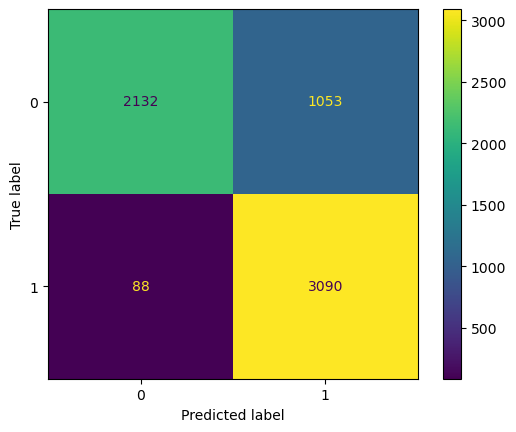

In [22]:
test_nn(n, reviews_dev, gold_labels_dev, max_count)

## Evaluation on test dataset

              precision    recall  f1-score   support

           0       0.95      0.68      0.79      3756
           1       0.75      0.97      0.84      3730

    accuracy                           0.82      7486
   macro avg       0.85      0.82      0.82      7486
weighted avg       0.85      0.82      0.82      7486

[[2544 1212]
 [ 123 3607]]


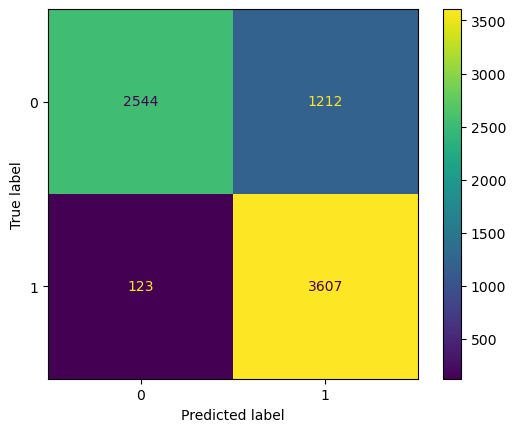

In [23]:
test_nn(n, reviews_test, gold_labels_test, max_count)